In [1]:
import cv2
import numpy as np
import pandas as pd
import random
import os

ModuleNotFoundError: No module named 'cv2'

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
def preprocess(totalLabels,stats, centroids):
    columns = ['label_id', 'left','top','width','height','area','centroid_x','centroid_y']
    df = pd.DataFrame(columns=columns)
    df['label_id'] = [i for i in range(1,totalLabels+1)]
    df['left'] = stats[:,0]
    df['top'] = stats[:,1]
    df['width'] = stats[:,2]
    df['height'] = stats[:,3]
    df['area'] = stats[:,4]
    df['centroid_x'] = centroids[:,0]
    df['centroid_y'] = centroids[:,1]
    return df

def preprocess_helper(df, min_ar_thresh=2, max_ar_thresh=6, pixel_row_gap = 10):
    df['aspect_ratio'] = np.round(df['width']/df['height'],2)
    df = df[(df['aspect_ratio'] > min_ar_thresh) & (df['aspect_ratio'] < max_ar_thresh)]
    df = df.sort_values(by=['top', 'left']).reset_index(drop=True)
    
    df['rowID'] = 1
    row_id = 1
    prev_val = df.loc[0, 'top']
    for idx in range(1, df.shape[0]):
        curr_val = df.loc[idx, 'top']
        if curr_val - prev_val > pixel_row_gap:
            row_id += 1
        prev_val = curr_val
        df.at[idx, 'rowID'] = int(row_id)

    df['columnID'] = df.groupby('rowID')['left'].rank().astype(int)
    return df

In [5]:
def build_single_lexicon(label_id, df, k=5):
    if label_id not in df['label_id'].values:
        print("unknown component")
        return
    x,y,w,h,r,c = df[df['label_id'] == label_id][['centroid_x','centroid_y','width','height','rowID','columnID']].values[0]
    r1 = (df['rowID'] >= r-1)
    r2 = (df['rowID'] <= r+1)    
    temp_df = df[r1 & r2]
    temp_df = temp_df[temp_df['label_id'] != label_id]
    
    #rotation-invariance
    
    #scale-invariance
    temp_df['new_centroid_x'] = (temp_df['centroid_x']-x)/w
    temp_df['new_centroid_y'] = (y-temp_df['centroid_y'])/h
    temp_df['new_left'] = (temp_df['left']-x)/w
    temp_df['new_top'] = (y-temp_df['top'])/h
    temp_df['new_width'] = temp_df['width']/w
    temp_df['new_height'] = temp_df['height']/h
    
    #calculate distance & angle
    temp_df['Euclidean'] = np.sqrt(temp_df['new_centroid_y']**2 + temp_df['new_centroid_x']**2)
    temp_df['theta'] = np.degrees(np.arctan2(temp_df['new_centroid_y'], temp_df['new_centroid_x']))
    temp_df['theta'] = (temp_df['theta'] + 360) % 360 
    temp_df.loc[temp_df['theta'] > 350, 'theta'] = 0
    temp_df.loc[temp_df['theta'] < 2, 'theta'] = 0
    temp_df['quadrant'] = pd.cut(temp_df['theta'], 8, labels=range(1,9))
     
    res_df = temp_df.sort_values(by=['Euclidean','theta'])[:k]
    res_df = res_df.sort_values(by=['theta'])
    
    res_df['tl_corner'] = res_df.apply(lambda row: (row['new_left'], row['new_top']), axis=1)
    res_df['br_corner'] = res_df.apply(lambda row: (row['new_left']+row['new_width'], row['new_top']+row['new_height']), axis=1)           
    return res_df

def build_context_layout(img,k_neigh = 5):
    bs = 5
    k = -0.2
    maxval = 255
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    imgThresh = cv2.ximgproc.niBlackThreshold(img1,maxValue=maxval,
                                               type=cv2.THRESH_BINARY,blockSize=bs,k=k)
    
    totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(imgThresh,4,cv2.CV_32S)
    df = preprocess(totalLabels,stats, centroid)
    df = preprocess_helper(df)
    #print("total no of words(>3 chars) identified:",df.shape[0])
    
    context_vectors = []
    context_coordinates = []
    for label in df.label_id.values:
        try:
            res = build_single_lexicon(label, df,k=k_neigh)
            if(res.shape[0] >= k_neigh):
                context_vectors.append(res[['tl_corner','br_corner']].values)
                coords = df[df['label_id'] == label][['centroid_x','centroid_y']].values
                context_coordinates.append(coords)
        except Exception as e:
            print()
        
            
    flattened_tuples = [np.array([item for sublist in t for item in sublist]) for t in context_vectors]
    array_of_tuples = np.array(flattened_tuples)
    context_vectors = array_of_tuples.reshape(len(context_vectors), k_neigh, 4)
    context_vectors = context_vectors.round(4)
    #print("total no of contexts extracted:",context_vectors.shape[0])
    
    return context_vectors,context_coordinates

In [6]:
def random_hash():
    random_bits = random.getrandbits(128)
    r_hash = "%032x" % random_bits
    return r_hash

def feature_distance(a,b):
    m,n = a.shape[0],b.shape[0]
    if(m > n):
        c = b
        b = a
        a = c
        m,n = a.shape[0],b.shape[0]
    distances = np.zeros(m)
    for i in range(m):
        dist = np.linalg.norm(b - a[i, np.newaxis, :, :], axis=(1, 2))
        closest_index = np.argmin(dist)
        distances[i] = dist[closest_index]
    distances = np.round(distances,2)
    total_distance = np.round(np.sum(distances),2)
    return distances,total_distance

class DocumentDetails():
    def __init__(self, img,id,feature_vectors,label_coordinates):
        self.img = img
        self.id = id
        self.feature_vectors = feature_vectors 
        self.label_coordinates = label_coordinates #saves each word coordinates indexed wrt to feature_vectors
        
class DocumentVectors():
    def __init__(self, img_folder_path):
        
        img_files = [file for file in os.listdir(img_folder_path) if file.endswith('.png')]
        img_file_paths = [os.path.join(img_folder_path, file_name) for file_name in img_files]
        
        #initialize variables
        self.img_file_paths = img_file_paths
        self.context_vectors = {}
        
    def build_context_vector_DB(self):
        for id,img_path in enumerate(self.img_file_paths):
            img = cv2.imread(img_path)
            feature_vectors,label_coordinates = build_context_layout(img)
            print(img_path, img.shape,id, feature_vectors.shape)
            
            h = random_hash()
            self.context_vectors[h] = DocumentDetails(img,id,feature_vectors,label_coordinates)
    
    def show_docs(self):
        for key in self.context_vectors.keys():
            doc = self.context_vectors[key]
            plt.figure(figsize=(6, 4))
            plt.imshow(doc.img)
            plt.title("ID:"+str(doc.id))
            plt.show()
            

    def query(self,query_img):
        query_vectors,query_coordinates = build_context_layout(query_img)
        print("found",len(query_vectors),"query vectors")
        
        min_score = 10000000
        result_doc = None
        
        for key in self.context_vectors.keys():
            doc = self.context_vectors[key]
            doc_vectors = doc.feature_vectors
            doc_id = doc.id
            img = doc.img
            _, score = feature_distance(doc_vectors,query_vectors)
            
            if score < min_score:
                min_score = score
                result_doc = img, doc_id, score
                
            print("doc_id:",doc_id,"score:",score)
            print("====================================")
            
        return result_doc
    
    def point_match(self,query_img,id):
        query_vectors,query_coordinates = build_context_layout(query_img)
        for key in self.context_vectors.keys():
            doc = self.context_vectors[key]
            if(id == doc.id):
                doc_vectors,doc_coordinates,doc_img = doc.feature_vectors,doc.label_coordinates,doc.img
                break
        matches1,matches2 = [],[]
        for i in range(len(query_vectors)):
            dist = np.linalg.norm(doc_vectors - query_vectors[i, np.newaxis, :, :], axis=(1, 2))
            closest_index = np.argmin(dist)
            query_coords = query_coordinates[i]
            doc_coords = doc_coordinates[closest_index]
            #print(i, query_coords, doc_coords)
            matches1.append(query_coords[0])
            matches2.append(doc_coords[0])
            
        return [query_img,doc_img,np.round(matches1,2),np.round(matches2,2)]

In [7]:
docs_path = './../../data/docs/'
dv = DocumentVectors(docs_path)
dv.build_context_vector_DB()

./../../data/docs/8.png (1664, 1238, 3) 0 (443, 5, 4)
./../../data/docs/9.png (1658, 1262, 3) 1 (429, 5, 4)
./../../data/docs/10.png (1770, 1270, 3) 2 (256, 5, 4)
./../../data/docs/4.png (1698, 1192, 3) 3 (193, 5, 4)
./../../data/docs/5.png (1710, 1296, 3) 4 (524, 5, 4)
./../../data/docs/7.png (1630, 1178, 3) 5 (176, 5, 4)
./../../data/docs/6.png (1726, 1306, 3) 6 (450, 5, 4)
./../../data/docs/2.png (1694, 1318, 3) 7 (513, 5, 4)
./../../data/docs/3.png (1704, 1300, 3) 8 (512, 5, 4)
./../../data/docs/1.png (1676, 1264, 3) 9 (407, 5, 4)


In [ ]:
dv.show_docs()

In [8]:
def random_quarter_crop(img):
    img_width, img_height,_ = img.shape
    max_left = img_width - img_width // 2
    max_top = img_height - img_height // 2
    left = random.randint(0, max_left)
    top = random.randint(0, max_top)
    crop_width = img_width // 2
    crop_height = img_height // 2
    cropped_img = img[left:left + crop_width, top:top + crop_height]
    return cropped_img

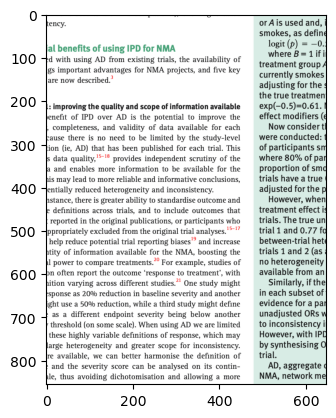

In [9]:
img_path = docs_path + str(5) + '.png'
img = cv2.imread(img_path)
img_c = random_quarter_crop(img)
plt.imshow(img_c)

In [10]:
res = dv.query(img_c)

found 185 query vectors
doc_id: 0 score: 688.43
doc_id: 1 score: 676.51
doc_id: 2 score: 665.43
doc_id: 3 score: 725.71
doc_id: 4 score: 501.77
doc_id: 5 score: 2573.52
doc_id: 6 score: 685.89
doc_id: 7 score: 679.75
doc_id: 8 score: 681.39
doc_id: 9 score: 675.97


(4, 501.77)

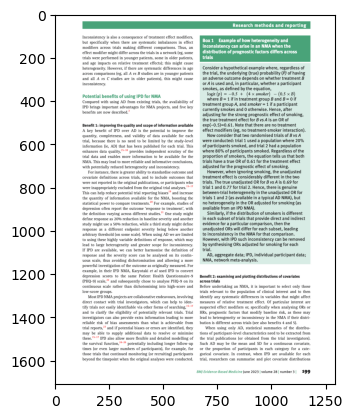

In [12]:
res_img, doc_id, score = res
plt.imshow(res_img)
doc_id, score

def custom_draw_matches(img1, img2, matches1, matches2):
    max_height = max(img1.shape[0], img2.shape[0])
    # Resize the images to a smaller size, while maintaining the aspect ratio.
    img1_resized = cv2.resize(img1, (int(img1.shape[1] / 2), int(max_height / 2)))
    img2_resized = cv2.resize(img2, (int(img2.shape[1] / 2), int(max_height / 2)))
    output_image = np.hstack((img1_resized, img2_resized))
    offset = img1_resized.shape[1]
    for match1, match2 in zip(matches1, matches2):
        (x1, y1) = match1
        (x1, y1) = (int(x1), int(y1))
        (x2, y2) = match2
        (x2, y2) = (int(x2), int(y2))
        # Scale the coordinates to match the resized images.
        x1 = int(x1 / 2)
        y1 = int(y1 / 2)
        x2 = int(x2 / 2) + offset
        y2 = int(y2 / 2)
        # Draw a line between the matching points on the output image.
        cv2.line(output_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
        # Display the output image.
    plt.imshow(output_image)
    plt.show()


In [13]:
def custom_draw_matches(img1, img2, matches1, matches2):
    max_height = max(img1.shape[0], img2.shape[0])
    # Resize the images to a smaller size, while maintaining the aspect ratio.
    img1_resized = cv2.resize(img1, (int(img1.shape[1] / 2), int(max_height / 2)))
    img2_resized = cv2.resize(img2, (int(img2.shape[1] / 2), int(max_height / 2)))
    output_image = np.hstack((img1_resized, img2_resized))
    offset = img1_resized.shape[1]

    # Reset size of matches1 and matches2 wrt to aspect ratio of image 1 and image2
    matches1_resized = []
    matches2_resized = []
    for match1, match2 in zip(matches1, matches2):
        (x1, y1) = match1
        (x2, y2) = match2

        # Scale the coordinates to match the resized images.
        x1 = int(x1 / 2)
        y1 = int(y1 / 2)
        x2 = int(x2 / 2) + offset
        y2 = int(y2 / 2)

        # Append the resized matches to the respective lists
        matches1_resized.append((x1, y1))
        matches2_resized.append((x2, y2))

    # Draw lines between the matching points on the output image.
    for match1, match2 in zip(matches1_resized, matches2_resized):
        (x1, y1) = match1
        (x2, y2) = match2
        cv2.line(output_image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Display the output image.
    plt.imshow(output_image)
    plt.show()


In [14]:
q,d,m1,m2 = dv.point_match(img_c, doc_id)

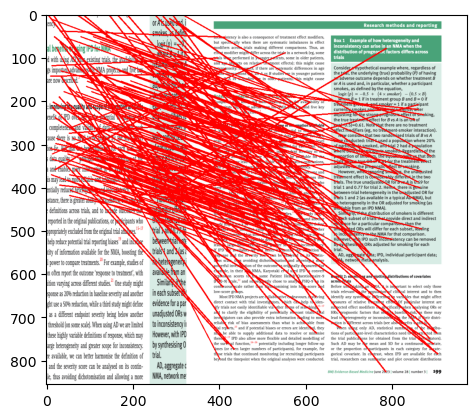

In [15]:
custom_draw_matches(q,d,m1,m2)

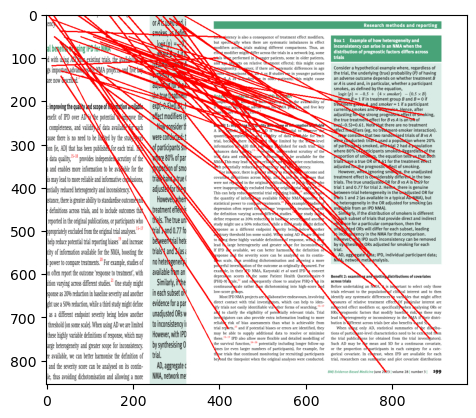

In [16]:
n = 50
custom_draw_matches(q,d,m1[:n],m2[:n])

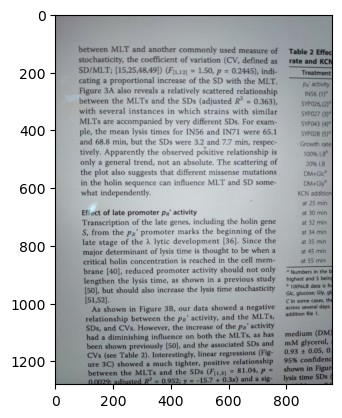

In [17]:
q2 = cv2.imread("./../../data/queries/2.jpeg")
plt.imshow(q2)

In [19]:
img_retr, doc_id, score = dv.query(q2)

found 722 query vectors
doc_id: 0 score: 2225.55
doc_id: 1 score: 1715.63
doc_id: 2 score: 1164.35
doc_id: 3 score: 1521.47
doc_id: 4 score: 1885.55
doc_id: 5 score: 2504.91
doc_id: 6 score: 3335.99
doc_id: 7 score: 1864.82
doc_id: 8 score: 2746.89
doc_id: 9 score: 1538.75


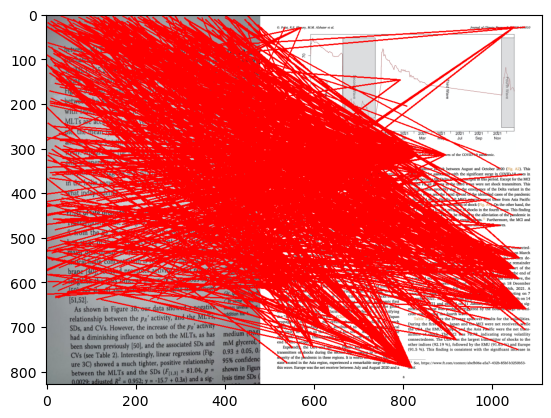

In [20]:
q,d,m1,m2 = dv.point_match(q2, 1)
custom_draw_matches(q,d,m1,m2)

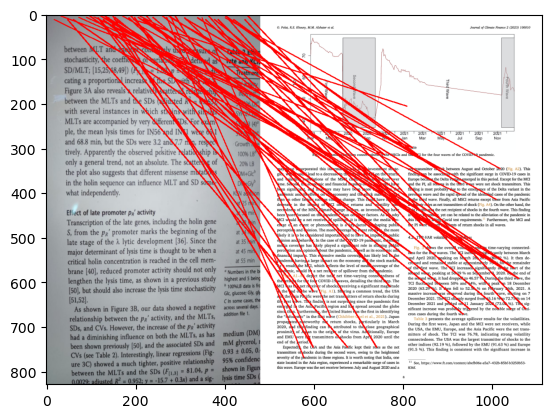

In [21]:
n = 50
custom_draw_matches(q,d,m1[:n],m2[:n])

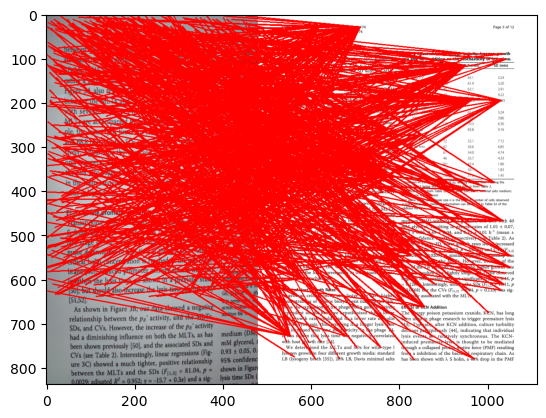

In [22]:
q,d,m1,m2 = dv.point_match(q2, 9)
custom_draw_matches(q,d,m1,m2)

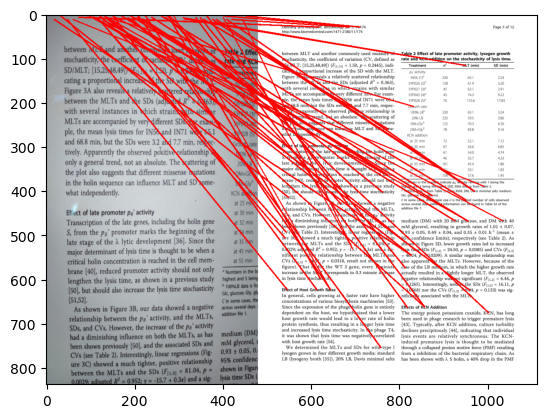

In [23]:
n = 50
custom_draw_matches(q,d,m1[:n],m2[:n])

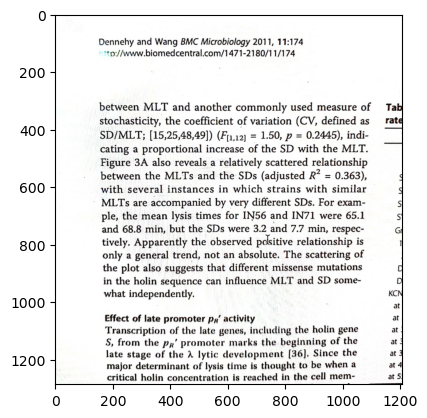

In [24]:
q11 = cv2.imread("./../../data/queries/1_CS.jpeg")
plt.imshow(q11)

In [25]:
_ = dv.query(q11)

found 269 query vectors
doc_id: 0 score: 11364.12
doc_id: 1 score: 12241.85
doc_id: 2 score: 1339.82
doc_id: 3 score: 1606.39
doc_id: 4 score: 12647.51
doc_id: 5 score: 2295.89
doc_id: 6 score: 11110.72
doc_id: 7 score: 12485.25
doc_id: 8 score: 11567.72
doc_id: 9 score: 12702.32


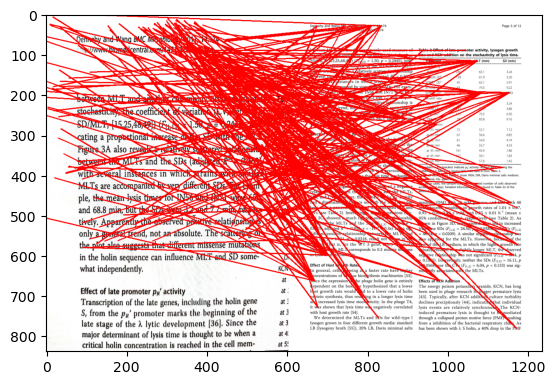

In [26]:
q,d,m1,m2 = dv.point_match(q11, 9)
custom_draw_matches(q,d,m1,m2)

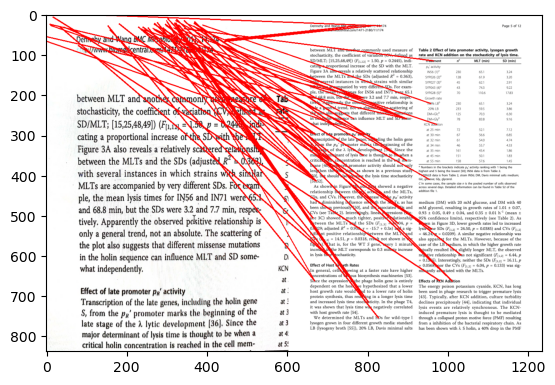

In [27]:
n = 50
custom_draw_matches(q,d,m1[:n],m2[:n])

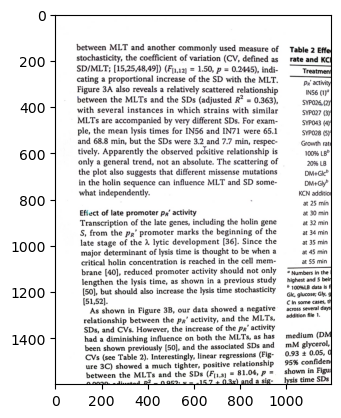

In [28]:
q21 = cv2.imread("./../../data/queries/2_CS.jpeg")
plt.imshow(q21)

In [29]:
_ = dv.query(q21)

found 362 query vectors
doc_id: 0 score: 25853.44
doc_id: 1 score: 25954.18
doc_id: 2 score: 1267.55
doc_id: 3 score: 1519.46
doc_id: 4 score: 27236.93
doc_id: 5 score: 2129.52
doc_id: 6 score: 25203.2
doc_id: 7 score: 26631.28
doc_id: 8 score: 23849.73
doc_id: 9 score: 27191.35


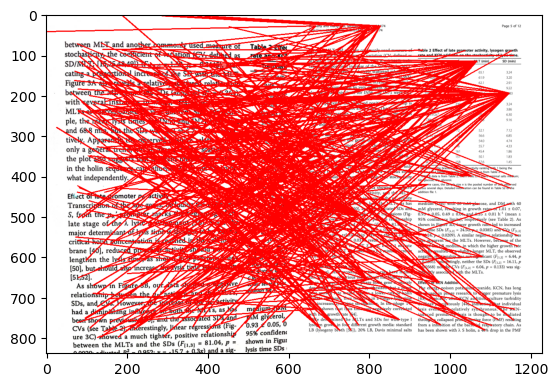

In [30]:
q,d,m1,m2 = dv.point_match(q21, 9)
custom_draw_matches(q,d,m1,m2)

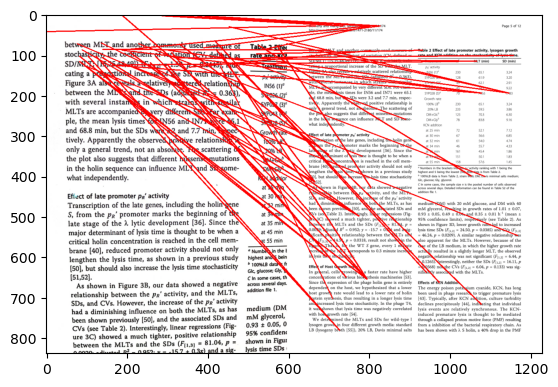

In [31]:
n = 50
custom_draw_matches(q,d,m1[:n],m2[:n])